In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from models.CRNN import CRNN_model

# 1. Data

In [5]:
strategy = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

strategy.ret.loc['2005-02-16'] = strategy.ret.loc['2005-02-17']

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2019-10-31 08:59:12,555 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:59:12,557 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:59:12,558 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


# 2. Explore

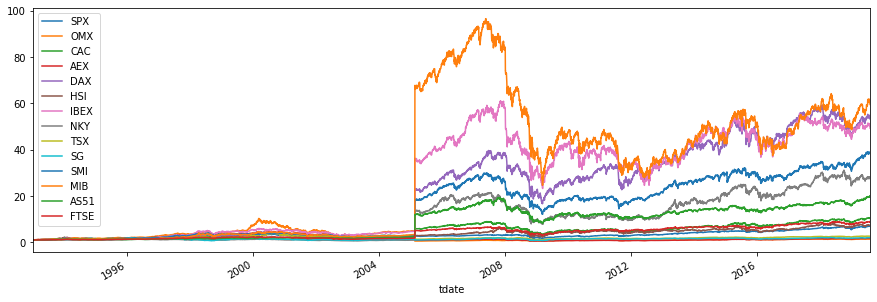

In [6]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

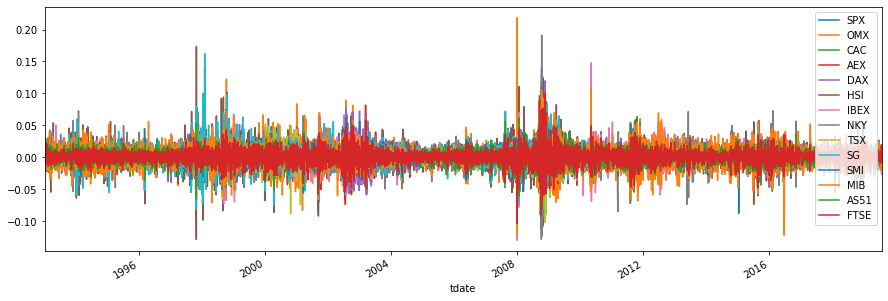

In [7]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [8]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 189, 252]

## 1. X

### moving average 와 주가 차이

In [9]:
moving_avg = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg['moving_average_' + str(period)] = df_index.rolling(period).mean() - df_index

### moving average  ratio

In [10]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    
    for i, period2 in enumerate(indiv_momentum_lst):

        moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period) + "_" + str(period2)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period2)

In [11]:
df_moving_avg = pd.concat(moving_avg, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average ratio 간 차이

In [12]:
moving_avg_columns = df_moving_avg_ratio.columns

for i, column1 in enumerate(moving_avg_columns[1:]):
    for j, column2 in enumerate(moving_avg_columns[2+i:]):
        df_moving_avg_ratio[column2 + " - " + column1] = df_moving_avg_ratio[column1] - df_moving_avg_ratio[column2]

# CASE 0. 기존

<img src="./result/EPM_PAST.png">

<img src="./result/EPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [13]:
one_week = 5
one_month = 20

In [14]:
df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

### binary - 50%

In [15]:
df_index_y_binary = df_index_rank > 7.5
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [16]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [17]:
df_moving_avg.reset_index(inplace=True)
df_moving_avg_ratio.reset_index(inplace=True)

df_join = pd.merge(df_y, df_moving_avg, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [18]:
df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [19]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [20]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.69268	valid_1's binary_logloss: 0.69268
[20]	training's binary_logloss: 0.692276	valid_1's binary_logloss: 0.692276
[30]	training's binary_logloss: 0.691909	valid_1's binary_logloss: 0.691909
[40]	training's binary_logloss: 0.69157	valid_1's binary_logloss: 0.69157
[50]	training's binary_logloss: 0.691268	valid_1's binary_logloss: 0.691268
[60]	training's binary_logloss: 0.69098	valid_1's binary_logloss: 0.69098
[70]	training's binary_logloss: 0.690711	valid_1's binary_logloss: 0.690711
[80]	training's binary_logloss: 0.690452	valid_1's binary_logloss: 0.690452
[90]	training's binary_logloss: 0.690207	valid_1's binary_logloss: 0.690207
[100]	training's binary_logloss: 0.689951	valid_1's binary_logloss: 0.689951
[110]	training's binary_logloss: 0.68971	valid_1's binary_logloss: 0.68971
[120]	training's binary_logloss: 0.689479	valid_1's binary_logloss: 0.689479
[130]	training's binary_logloss

In [21]:
test_pred = model.predict(df_test_x.values)

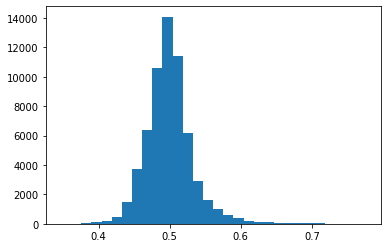

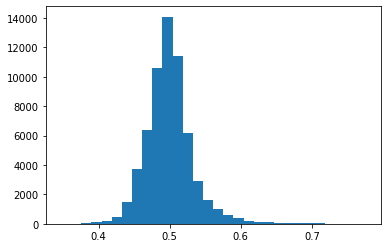

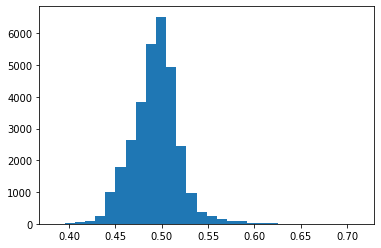

In [22]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [23]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [25]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [26]:
df_index_sub = df_index.loc['1994':]

In [27]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [28]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [29]:
strategy.set_rebalance_period(freq='week', rebalance_weekday=1) 

2019-10-31 08:59:17,948 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [30]:
tester = Tester(strategy)

In [31]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [32]:
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2019-10-31 08:59:17,979 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:59:17,980 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:59:17,980 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 08:59:33,736 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 08:59:33,737 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 08:59:36,070 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-31 08:59:36,080 - EPM - INFO - [STEP 5 - 2 - 3] STRATEGY LEVEL VOL CONTROL to TS POSITION
2019-10-31 08:59:37,785 - EPM - INFO - [STEP 5 - 2 - 4] MAKE FINAL TS POSITION
2019-10-31 08:59:37,788 - EPM - INFO - [STEP 5 - 3] MAKE CS POSITION
2019-10-31 08:59:37,789 - EPM - INFO - [STEP 5 - 3 - 1] NO TARGET VOL CONTROL to CS POSITION
2019-10-31 08:59:37,790 - EPM - INFO - [STEP 5 - 3 - 2] ALIGN CS POSITION WITH REBALANCE DAY
2019-10-31 08:59:49,102 - EPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITION
2019-10-31

### TRAIN

2019-10-31 08:59:50,508 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:59:50,509 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:59:50,516 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:59:50,524 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


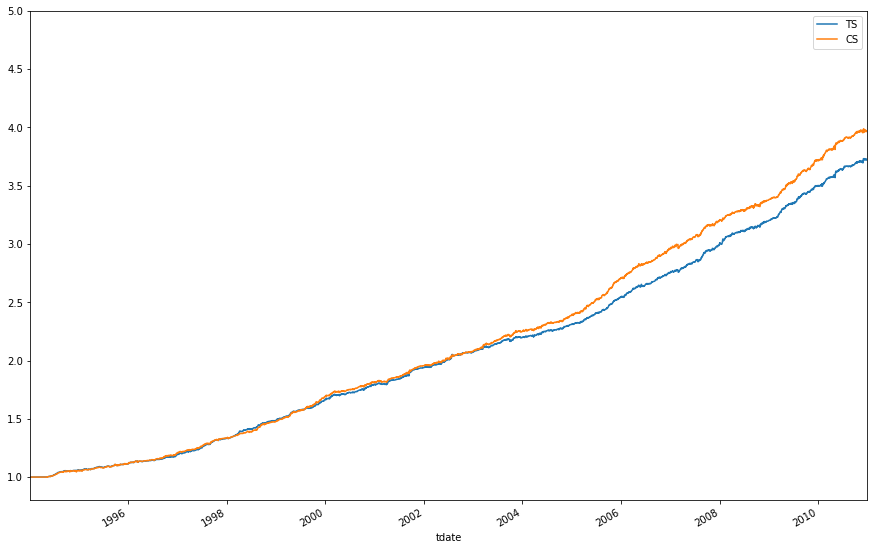

In [33]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-31 08:59:50,682 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:59:50,683 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:59:50,692 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:59:50,700 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


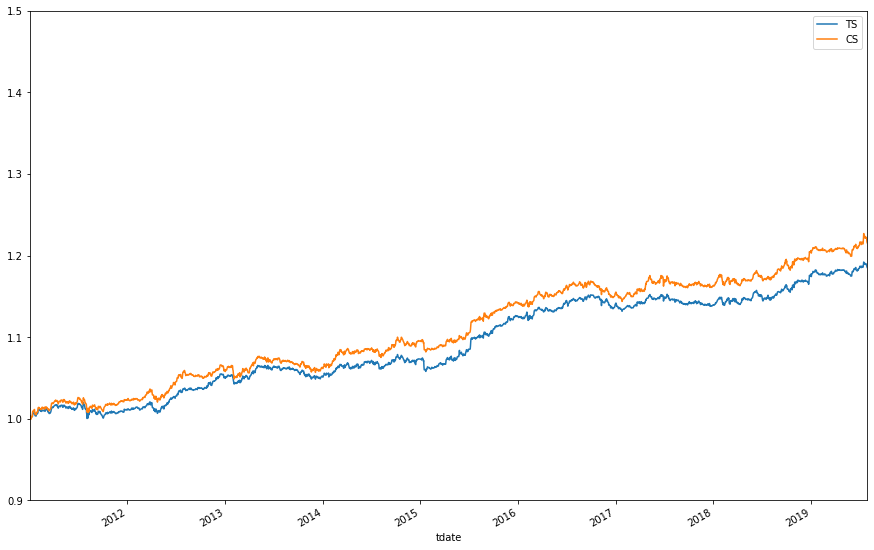

In [34]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [35]:
one_week = 5
one_month = 20

df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [36]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [37]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [38]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [39]:
df_join2 = pd.merge(df_y2, df_moving_avg, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [40]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [41]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686133	valid_1's binary_logloss: 0.697435
[20]	training's binary_logloss: 0.685414	valid_1's binary_logloss: 0.697039
[30]	training's binary_logloss: 0.68478	valid_1's binary_logloss: 0.696742
[40]	training's binary_logloss: 0.684206	valid_1's binary_logloss: 0.696516
[50]	training's binary_logloss: 0.68369	valid_1's binary_logloss: 0.696307
[60]	training's binary_logloss: 0.683207	valid_1's binary_logloss: 0.696104
[70]	training's binary_logloss: 0.682745	valid_1's binary_logloss: 0.695922
[80]	training's binary_logloss: 0.682295	valid_1's binary_logloss: 0.695764
[90]	training's binary_logloss: 0.681856	valid_1's binary_logloss: 0.695641
[100]	training's binary_logloss: 0.681422	valid_1's binary_logloss: 0.695503
[110]	training's binary_logloss: 0.681032	valid_1's binary_logloss: 0.695394
[120]	training's binary_logloss: 0.680628	valid_1's binary_logloss: 0.695308
[130]	training's binary_l

In [42]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

(array([1.0000e+01, 4.2000e+01, 9.7000e+01, 2.2400e+02, 4.1700e+02,
        8.3500e+02, 2.5050e+03, 5.1620e+03, 6.9970e+03, 1.0491e+04,
        1.5551e+04, 1.9989e+04, 1.6123e+04, 7.7210e+03, 2.9040e+03,
        1.4750e+03, 9.6000e+02, 5.7800e+02, 3.8600e+02, 2.2100e+02,
        1.5200e+02, 1.0800e+02, 7.2000e+01, 5.9000e+01, 3.3000e+01,
        2.6000e+01, 2.1000e+01, 1.3000e+01, 3.0000e+00, 9.0000e+00]),
 array([0.36247023, 0.379666  , 0.39686178, 0.41405755, 0.43125332,
        0.4484491 , 0.46564487, 0.48284065, 0.50003642, 0.51723219,
        0.53442797, 0.55162374, 0.56881951, 0.58601529, 0.60321106,
        0.62040684, 0.63760261, 0.65479838, 0.67199416, 0.68918993,
        0.70638571, 0.72358148, 0.74077725, 0.75797303, 0.7751688 ,
        0.79236458, 0.80956035, 0.82675612, 0.8439519 , 0.86114767,
        0.87834344]),
 <a list of 30 Patch objects>)

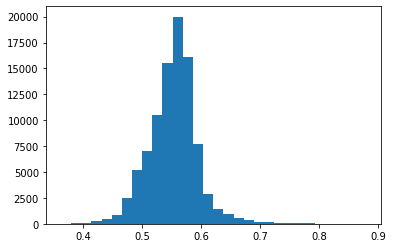

In [43]:
plt.hist(pred2, bins=30)

In [44]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [45]:
strategy2 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy2.load_index_and_return(from_db=False, save_file=False)

strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'

strategy2.index.index.name = 'tdate'
strategy2.ret.index.name = 'tdate'

strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

strategy2.ret.loc['2005-02-16'] = strategy2.ret.loc['2005-02-17']

2019-10-31 08:59:53,365 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:59:53,365 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:59:53,367 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:59:53,367 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:59:53,368 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 08:59:53,368 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [46]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='notional')
strategy2.make_portfolio()

2019-10-31 08:59:53,413 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:59:53,413 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:59:53,414 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:59:53,414 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:59:53,414 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:59:53,414 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:59:53,415 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 08:59:53,415 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:00:09,170 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:00:09,170 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:00:09,172 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 09:00:09,172 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 09:00:11,457 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-31 09:00:11,457 - EPM - 

### TRAIN

2019-10-31 09:00:24,455 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:00:24,455 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:00:24,456 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:00:24,456 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:00:24,465 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:00:24,465 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:00:24,473 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:00:24,473 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


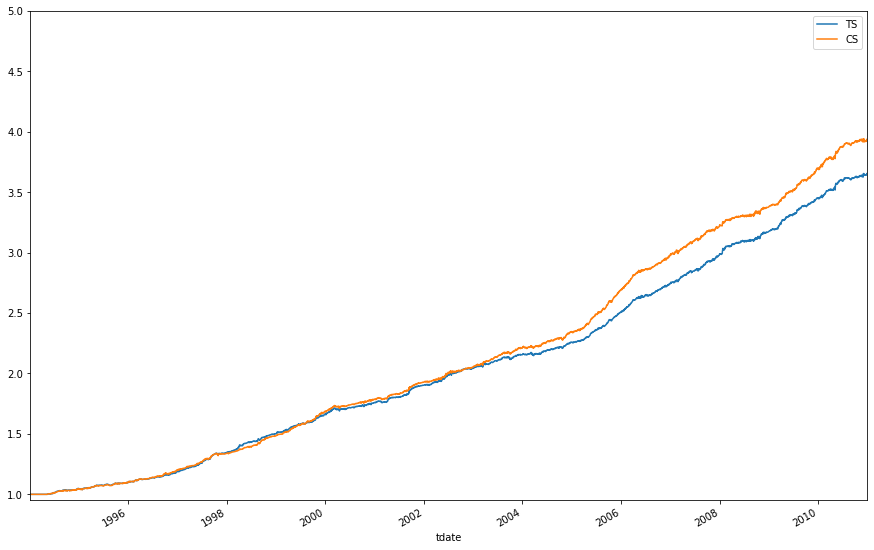

In [47]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

2019-10-31 09:00:24,644 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:00:24,644 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:00:24,645 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:00:24,645 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:00:24,652 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:00:24,652 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:00:24,660 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:00:24,660 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


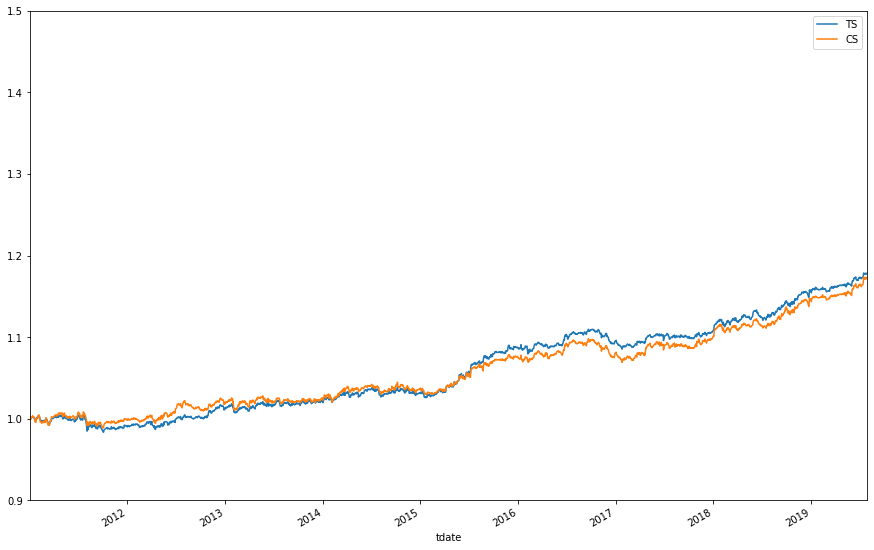

In [48]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))

# CASE 3. Case1을 Rolling으로 실행

In [49]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [50]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [51]:
models = []
train_preds = []
test_preds = []

In [52]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.69268	valid_1's binary_logloss: 0.692857
[20]	training's binary_logloss: 0.692276	valid_1's binary_logloss: 0.692665
[30]	training's binary_logloss: 0.691909	valid_1's binary_logloss: 0.692497
[40]	training's binary_logloss: 0.69157	valid_1's binary_logloss: 0.692341
[50]	training's binary_logloss: 0.691268	valid_1's binary_logloss: 0.692212
[60]	training's binary_logloss: 0.69098	valid_1's binary_logloss: 0.692184
[70]	training's binary_logloss: 0.690711	valid_1's binary_logloss: 0.692145
[80]	training's binary_logloss: 0.690452	valid_1's binary_logloss: 0.692144
[90]	training's binary_logloss: 0.690207	valid_1's binary_logloss: 0.69211
[100]	training's binary_logloss: 0.689951	valid_1's binary_logloss: 0.692078
[110]	training's binary_logloss: 0.68971	valid_1's binary_logloss: 0.692028
[120]	training's binary_logloss: 0.689479	valid_1's binary_logloss: 0.691955
[130]	training's binary_logl

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692715	valid_1's binary_logloss: 0.692896
[20]	training's binary_logloss: 0.692326	valid_1's binary_logloss: 0.692695
[30]	training's binary_logloss: 0.691972	valid_1's binary_logloss: 0.692541
[40]	training's binary_logloss: 0.69165	valid_1's binary_logloss: 0.692393
[50]	training's binary_logloss: 0.691354	valid_1's binary_logloss: 0.692278
[60]	training's binary_logloss: 0.691075	valid_1's binary_logloss: 0.692188
[70]	training's binary_logloss: 0.690817	valid_1's binary_logloss: 0.692094
[80]	training's binary_logloss: 0.690565	valid_1's binary_logloss: 0.692046
[90]	training's binary_logloss: 0.690323	valid_1's binary_logloss: 0.691968
[100]	training's binary_logloss: 0.690088	valid_1's binary_logloss: 0.691941
[110]	training's binary_logloss: 0.68987	valid_1's binary_logloss: 0.691934
[120]	training's binary_logloss: 0.689674	valid_1's binary_logloss: 0.691916
[130]	training's binary_l

[40]	training's binary_logloss: 0.691719	valid_1's binary_logloss: 0.692762
[50]	training's binary_logloss: 0.691445	valid_1's binary_logloss: 0.692686
[60]	training's binary_logloss: 0.691189	valid_1's binary_logloss: 0.6926
[70]	training's binary_logloss: 0.690944	valid_1's binary_logloss: 0.692569
[80]	training's binary_logloss: 0.690713	valid_1's binary_logloss: 0.692565
[90]	training's binary_logloss: 0.690489	valid_1's binary_logloss: 0.692573
[100]	training's binary_logloss: 0.690287	valid_1's binary_logloss: 0.692553
[110]	training's binary_logloss: 0.690101	valid_1's binary_logloss: 0.692535
[120]	training's binary_logloss: 0.689918	valid_1's binary_logloss: 0.692521
[130]	training's binary_logloss: 0.689743	valid_1's binary_logloss: 0.692527
[140]	training's binary_logloss: 0.689564	valid_1's binary_logloss: 0.692475
[150]	training's binary_logloss: 0.689395	valid_1's binary_logloss: 0.692443
[160]	training's binary_logloss: 0.689235	valid_1's binary_logloss: 0.692373
[170]	t

[80]	training's binary_logloss: 0.690918	valid_1's binary_logloss: 0.69225
[90]	training's binary_logloss: 0.690729	valid_1's binary_logloss: 0.692242
[100]	training's binary_logloss: 0.69054	valid_1's binary_logloss: 0.692277
[110]	training's binary_logloss: 0.690357	valid_1's binary_logloss: 0.692299
[120]	training's binary_logloss: 0.690176	valid_1's binary_logloss: 0.692286
[130]	training's binary_logloss: 0.690006	valid_1's binary_logloss: 0.692298
[140]	training's binary_logloss: 0.689841	valid_1's binary_logloss: 0.692293
[150]	training's binary_logloss: 0.689677	valid_1's binary_logloss: 0.692292
[160]	training's binary_logloss: 0.68952	valid_1's binary_logloss: 0.692313
[170]	training's binary_logloss: 0.689367	valid_1's binary_logloss: 0.692355
[180]	training's binary_logloss: 0.689214	valid_1's binary_logloss: 0.692377
[190]	training's binary_logloss: 0.689071	valid_1's binary_logloss: 0.69237
[200]	training's binary_logloss: 0.688909	valid_1's binary_logloss: 0.692384
[210]

[130]	training's binary_logloss: 0.69024	valid_1's binary_logloss: 0.691706
[140]	training's binary_logloss: 0.690097	valid_1's binary_logloss: 0.691703
[150]	training's binary_logloss: 0.689961	valid_1's binary_logloss: 0.691661
[160]	training's binary_logloss: 0.689816	valid_1's binary_logloss: 0.691654
[170]	training's binary_logloss: 0.689683	valid_1's binary_logloss: 0.691641
[180]	training's binary_logloss: 0.689535	valid_1's binary_logloss: 0.69161
[190]	training's binary_logloss: 0.689396	valid_1's binary_logloss: 0.691621
[200]	training's binary_logloss: 0.689257	valid_1's binary_logloss: 0.691621
[210]	training's binary_logloss: 0.689112	valid_1's binary_logloss: 0.691605
[220]	training's binary_logloss: 0.68898	valid_1's binary_logloss: 0.691626
[230]	training's binary_logloss: 0.688849	valid_1's binary_logloss: 0.691613
[240]	training's binary_logloss: 0.688722	valid_1's binary_logloss: 0.69161
[250]	training's binary_logloss: 0.688602	valid_1's binary_logloss: 0.691601
[26

In [53]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([1.800e+01, 3.500e+01, 3.300e+01, 1.130e+02, 2.570e+02, 8.180e+02,
        1.895e+03, 3.702e+03, 5.538e+03, 6.544e+03, 5.757e+03, 3.291e+03,
        1.757e+03, 7.420e+02, 2.870e+02, 1.530e+02, 9.200e+01, 7.300e+01,
        6.900e+01, 4.000e+01, 1.800e+01, 1.200e+01, 9.000e+00, 1.200e+01,
        9.000e+00, 4.000e+00, 5.000e+00, 3.000e+00, 3.000e+00, 1.000e+00]),
 array([0.39333945, 0.40398923, 0.414639  , 0.42528878, 0.43593856,
        0.44658834, 0.45723811, 0.46788789, 0.47853767, 0.48918745,
        0.49983722, 0.510487  , 0.52113678, 0.53178656, 0.54243634,
        0.55308611, 0.56373589, 0.57438567, 0.58503545, 0.59568522,
        0.606335  , 0.61698478, 0.62763456, 0.63828434, 0.64893411,
        0.65958389, 0.67023367, 0.68088345, 0.69153322, 0.702183  ,
        0.71283278]),
 <a list of 30 Patch objects>)

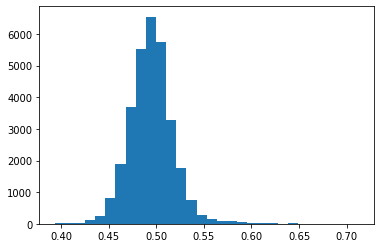

In [54]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [55]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [56]:
strategy3 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy3.load_index_and_return(from_db=False, save_file=False)

strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'

strategy3.index.index.name = 'tdate'
strategy3.ret.index.name = 'tdate'

strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

strategy3.ret.loc['2005-02-16'] = strategy3.ret.loc['2005-02-17']

2019-10-31 09:00:50,235 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:00:50,235 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:00:50,235 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:00:50,236 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:00:50,236 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:00:50,236 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:00:50,237 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:00:50,237 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:00:50,237 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [57]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

2019-10-31 09:00:50,291 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:00:50,291 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:00:50,291 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:00:50,292 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:00:50,292 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:00:50,292 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:00:50,293 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:00:50,293 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:00:50,293 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:00:50,294 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:00:50,294 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:00:50,294 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:01:04,699 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:01:04,699 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:01:04,699 - EPM -

2019-10-31 09:01:08,969 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:01:08,969 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:01:08,969 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:01:08,971 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:01:08,971 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:01:08,971 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:01:08,978 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:01:08,978 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:01:08,978 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:01:08,985 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:01:08,985 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:01:08,985 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


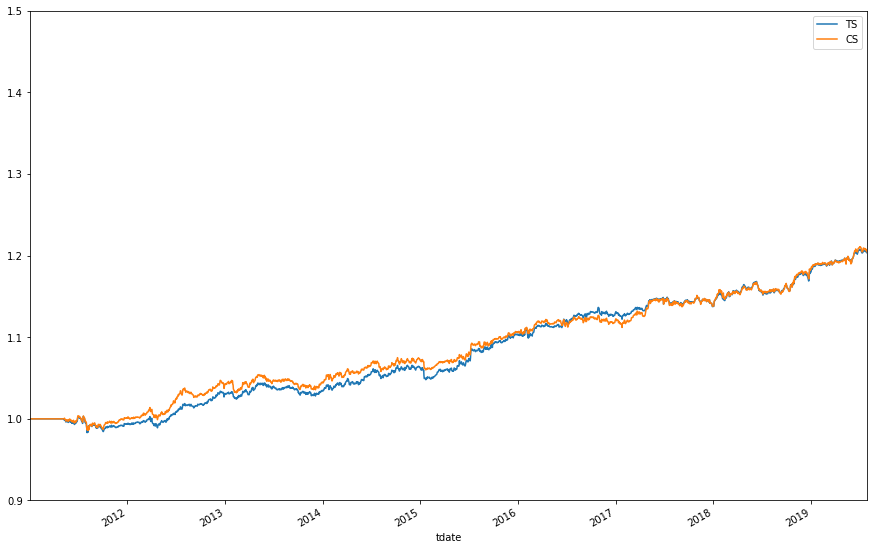

In [58]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))

# CASE 4. CASE 2를 ROLLING으로 실행

In [59]:
models = []
train_preds = []
test_preds = []

In [60]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686133	valid_1's binary_logloss: 0.699315
[20]	training's binary_logloss: 0.685414	valid_1's binary_logloss: 0.699342
[30]	training's binary_logloss: 0.68478	valid_1's binary_logloss: 0.699393
[40]	training's binary_logloss: 0.684206	valid_1's binary_logloss: 0.699481
[50]	training's binary_logloss: 0.68369	valid_1's binary_logloss: 0.699674
[60]	training's binary_logloss: 0.683207	valid_1's binary_logloss: 0.699835
[70]	training's binary_logloss: 0.682745	valid_1's binary_logloss: 0.69994
[80]	training's binary_logloss: 0.682295	valid_1's binary_logloss: 0.700098
[90]	training's binary_logloss: 0.681856	valid_1's binary_logloss: 0.700378
[100]	training's binary_logloss: 0.681422	valid_1's binary_logloss: 0.700673
[110]	training's binary_logloss: 0.681032	valid_1's binary_logloss: 0.700851
[120]	training's binary_logloss: 0.680628	valid_1's binary_logloss: 0.701117
[130]	training's binary_lo

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686184	valid_1's binary_logloss: 0.698898
[20]	training's binary_logloss: 0.685487	valid_1's binary_logloss: 0.698551
[30]	training's binary_logloss: 0.684873	valid_1's binary_logloss: 0.69827
[40]	training's binary_logloss: 0.684329	valid_1's binary_logloss: 0.698075
[50]	training's binary_logloss: 0.683822	valid_1's binary_logloss: 0.697824
[60]	training's binary_logloss: 0.683353	valid_1's binary_logloss: 0.6976
[70]	training's binary_logloss: 0.682915	valid_1's binary_logloss: 0.697318
[80]	training's binary_logloss: 0.682494	valid_1's binary_logloss: 0.697085
[90]	training's binary_logloss: 0.682083	valid_1's binary_logloss: 0.696976
[100]	training's binary_logloss: 0.681691	valid_1's binary_logloss: 0.697006
[110]	training's binary_logloss: 0.68133	valid_1's binary_logloss: 0.697025
[120]	training's binary_logloss: 0.680977	valid_1's binary_logloss: 0.697094
[130]	training's binary_log

[100]	training's binary_logloss: 0.682074	valid_1's binary_logloss: 0.69777
[110]	training's binary_logloss: 0.681777	valid_1's binary_logloss: 0.697756
[120]	training's binary_logloss: 0.681467	valid_1's binary_logloss: 0.697755
[130]	training's binary_logloss: 0.681161	valid_1's binary_logloss: 0.697762
[140]	training's binary_logloss: 0.680845	valid_1's binary_logloss: 0.69777
[150]	training's binary_logloss: 0.680553	valid_1's binary_logloss: 0.697789
[160]	training's binary_logloss: 0.680269	valid_1's binary_logloss: 0.69782
[170]	training's binary_logloss: 0.679993	valid_1's binary_logloss: 0.697804
[180]	training's binary_logloss: 0.679721	valid_1's binary_logloss: 0.697864
[190]	training's binary_logloss: 0.679457	valid_1's binary_logloss: 0.697889
[200]	training's binary_logloss: 0.679175	valid_1's binary_logloss: 0.697958
[210]	training's binary_logloss: 0.678903	valid_1's binary_logloss: 0.697944
[220]	training's binary_logloss: 0.678642	valid_1's binary_logloss: 0.697942
[2

[180]	training's binary_logloss: 0.680189	valid_1's binary_logloss: 0.70031
[190]	training's binary_logloss: 0.67995	valid_1's binary_logloss: 0.70037
[200]	training's binary_logloss: 0.679702	valid_1's binary_logloss: 0.700461
[210]	training's binary_logloss: 0.679467	valid_1's binary_logloss: 0.700518
[220]	training's binary_logloss: 0.679246	valid_1's binary_logloss: 0.70065
[230]	training's binary_logloss: 0.679023	valid_1's binary_logloss: 0.700733
[240]	training's binary_logloss: 0.678805	valid_1's binary_logloss: 0.700814
[250]	training's binary_logloss: 0.678586	valid_1's binary_logloss: 0.700905
[260]	training's binary_logloss: 0.678373	valid_1's binary_logloss: 0.700974
[270]	training's binary_logloss: 0.678152	valid_1's binary_logloss: 0.701004
[280]	training's binary_logloss: 0.677947	valid_1's binary_logloss: 0.70111
[290]	training's binary_logloss: 0.677726	valid_1's binary_logloss: 0.701246
[300]	training's binary_logloss: 0.677514	valid_1's binary_logloss: 0.701278
[310

[240]	training's binary_logloss: 0.679534	valid_1's binary_logloss: 0.697494
[250]	training's binary_logloss: 0.67934	valid_1's binary_logloss: 0.697464
[260]	training's binary_logloss: 0.679122	valid_1's binary_logloss: 0.697398
[270]	training's binary_logloss: 0.678926	valid_1's binary_logloss: 0.697409
[280]	training's binary_logloss: 0.678736	valid_1's binary_logloss: 0.697413
[290]	training's binary_logloss: 0.678543	valid_1's binary_logloss: 0.69736
[300]	training's binary_logloss: 0.678327	valid_1's binary_logloss: 0.697306
[310]	training's binary_logloss: 0.678102	valid_1's binary_logloss: 0.697256
[320]	training's binary_logloss: 0.677899	valid_1's binary_logloss: 0.697142
[330]	training's binary_logloss: 0.67769	valid_1's binary_logloss: 0.697084
[340]	training's binary_logloss: 0.677472	valid_1's binary_logloss: 0.697102
[350]	training's binary_logloss: 0.67727	valid_1's binary_logloss: 0.697049
[360]	training's binary_logloss: 0.677072	valid_1's binary_logloss: 0.697025
[37

In [61]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [62]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [63]:
strategy4 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy4.load_index_and_return(from_db=False, save_file=False)

strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'

strategy4.index.index.name = 'tdate'
strategy4.ret.index.name = 'tdate'

strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

strategy4.ret.loc['2005-02-16'] = strategy4.ret.loc['2005-02-17']

2019-10-31 09:01:21,524 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:01:21,524 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:01:21,524 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:01:21,524 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:01:21,527 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:01:21,527 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:01:21,527 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:01:21,527 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:01:21,529 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:01:21,529 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:01:21,529 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:01:21,529 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [64]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

2019-10-31 09:01:21,583 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:01:21,583 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:01:21,583 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:01:21,583 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:01:21,584 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:01:21,584 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:01:21,584 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:01:21,584 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:01:21,585 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:01:21,585 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:01:21,585 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:01:21,585 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:01:21,587 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:01:21,587 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:01:21,587 - EPM - INFO -

2019-10-31 09:01:39,377 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:01:39,377 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:01:39,377 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:01:39,377 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:01:39,379 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:01:39,379 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:01:39,379 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:01:39,379 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:01:39,387 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:01:39,387 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:01:39,387 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:01:39,387 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:01:39,396 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:01:39,396 - EPM - INFO - [STEP 7]

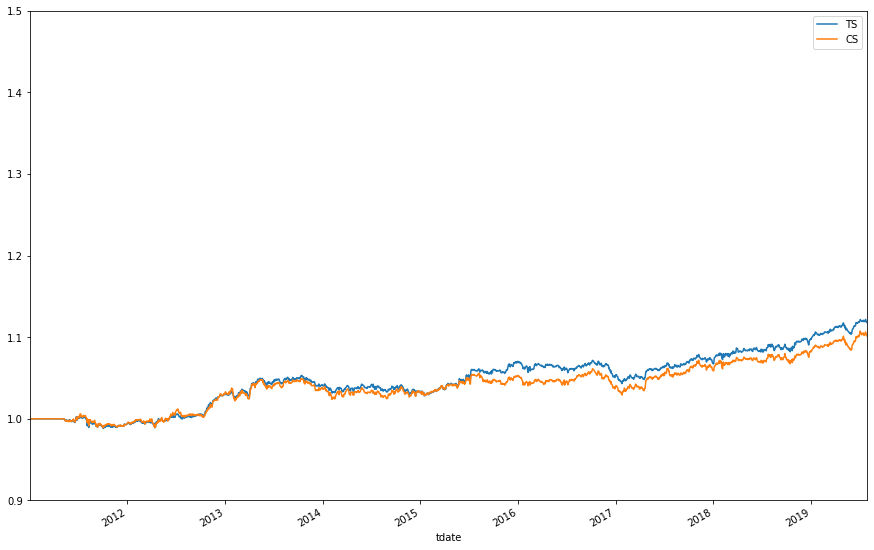

In [65]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))